In [1]:
# @title Imports
import numpy as np
import BOLDFilters as BOLDFilters
import neurolib.utils.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
from petTOAD_setup import *
from scipy.signal import welch as welch

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


In [2]:
# Define functions

###################################################################
############## Taken from Gustavo Patow's code ####################
###################################################################


def conv(u, v):  # python equivalent to matlab conv 'same' method
    # from https://stackoverflow.com/questions/38194270/matlab-convolution-same-to-numpy-convolve
    npad = len(v) - 1
    full = np.convolve(u, v, "full")
    first = npad - npad // 2
    return full[first : first + len(u)]


def gaussfilt(t, z, sigma):
    # Apply a Gaussian filter to a time series
    #    Inputs: t = independent variable, z = data at points t, and
    #        sigma = standard deviation of Gaussian filter to be applied.
    #    Outputs: zfilt = filtered data.
    #
    #    based on the code by James Conder. Aug 22, 2013
    #    (partial) translation by Gustavo Patow
    n = z.size  # number of data
    a = 1 / (np.sqrt(2 * np.pi) * sigma)  # height of Gaussian
    sigma2 = sigma * sigma

    # check for uniform spacing
    # if so, use convolution. if not use numerical integration
    # uniform = false;
    dt = np.diff(t)
    dt = dt[0]
    # Only the uniform option is considered
    filter = dt * a * np.exp(-0.5 * ((t - np.mean(t)) ** 2) / sigma2)
    i = filter < dt * a * 1.0e-6
    filter = np.delete(filter, i)  # filter[i] = []
    zfilt = conv(z, filter)
    onesToFilt = np.ones(np.size(z))  # remove edge effect from conv
    onesFilt = conv(onesToFilt, filter)
    zfilt = zfilt / onesFilt

    return zfilt


def filtPowSpetra(signal, TR):
    nNodes, Tmax = signal.shape  # Here we are assuming we receive only ONE subject...
    ts_filt_narrow = BOLDFilters.BandPassFilter(signal, removeStrongArtefacts=False)
    pw_filt_narrow = np.abs(np.fft.fft(ts_filt_narrow, axis=1))
    PowSpect_filt_narrow = pw_filt_narrow[:, 0 : int(np.floor(Tmax / 2))].T ** 2 / (
        Tmax / TR
    )
    return PowSpect_filt_narrow


def filtPowSpetraMultipleSubjects(signal, TR, smooth=True):
    if signal.ndim == 2:
        print("I am doing one subject")
        nSubjects = 1
        (
            nNodes,
            Tmax,
        ) = signal.shape  # Here we are assuming we receive only ONE subject...
        Power_Areas_filt_narrow_unsmoothed = filtPowSpetra(signal, TR)
    else:
        print("I am doing more than one subject")
        # In case we receive more than one subject, we do a mean...
        nSubjects, nNodes, Tmax = signal.shape
        PowSpect_filt_narrow = np.zeros((nSubjects, nNodes, int(np.floor(Tmax / 2))))
        for s in range(nSubjects):
            print(f"filtPowSpectraMultipleSubjects: subject {s+1} (of {nSubjects})")
            PowSpect_filt_narrow[s] = filtPowSpetra(signal[s, :, :], TR).T
        Power_Areas_filt_narrow_unsmoothed = np.mean(PowSpect_filt_narrow, axis=0).T
    Power_Areas_filt_narrow_smoothed = np.zeros_like(Power_Areas_filt_narrow_unsmoothed)
    Ts = Tmax * TR
    freqs = np.arange(0, Tmax / 2 - 1) / Ts
    for seed in np.arange(nNodes):
        Power_Areas_filt_narrow_smoothed[:, seed] = gaussfilt(
            freqs, Power_Areas_filt_narrow_unsmoothed[:, seed], 0.01
        )
    # Added only smooth / unsmooth option
    if smooth:
        idxFreqOfMaxPwr = np.argmax(Power_Areas_filt_narrow_smoothed, axis=0)
    else:
        idxFreqOfMaxPwr = np.argmax(Power_Areas_filt_narrow_unsmoothed, axis=0)
    f_diff = freqs[idxFreqOfMaxPwr]
    return f_diff


###########################################################################################################################
############################### END of Gustavo Patow's functions ##########################################################
###########################################################################################################################


# My way to get intrinsic frequencies using Welch's method
def ws_group_welch(ts_group):
    fs = 1 / TR
    fs_group = []
    for i in range(ts_group.shape[0]):
        fs_subj = []
        for ts_roi in ts_group[i]:
            (f, S) = welch(ts_roi, fs, nperseg=193)
            fs_subj.append(f[np.argmax(S)])
        fs_group.append(fs_subj)
    return np.array(fs_group).mean(axis=0)

One thing I noticed is that Gustavo Patow's method for getting the intrinsic frequencies, determines the same w for all the groups, so this might somehow influence the between-group differences. The main reason for this is the Gaussian Smoothing (also done by Deco lab, though). I try both smoothing and without smoothing and I also add another way of calculating the power spectrum with the Welch's method. 

In [3]:
# Prepare data
# Get the timeseries for the chosen group
group_hc_no_wmh, timeseries_hc_no_wmh = get_group_ts_for_freqs(
    HC_no_WMH, all_fMRI_clean
)
group_hc_wmh, timeseries_hc_wmh = get_group_ts_for_freqs(HC_WMH, all_fMRI_clean)
group_mci_no_wmh, timeseries_mci_no_wmh = get_group_ts_for_freqs(
    MCI_no_WMH, all_fMRI_clean
)
group_mci_wmh, timeseries_mci_wmh = get_group_ts_for_freqs(MCI_WMH, all_fMRI_clean)
timeseries_all = np.concatenate(
    [timeseries_hc_no_wmh, timeseries_hc_wmh, timeseries_mci_no_wmh, timeseries_mci_wmh]
)

# %%
f_diff_hc_no_wmh_smooth = filtPowSpetraMultipleSubjects(timeseries_hc_no_wmh, TR)
f_diff_hc_wmh_smooth = filtPowSpetraMultipleSubjects(timeseries_hc_wmh, TR)
f_diff_mci_no_wmh_smooth = filtPowSpetraMultipleSubjects(timeseries_mci_no_wmh, TR)
f_diff_mci_wmh_smooth = filtPowSpetraMultipleSubjects(timeseries_mci_wmh, TR)
f_diff_all_smooth = filtPowSpetraMultipleSubjects(timeseries_all, TR)

f_diff_hc_no_wmh_unsmooth = filtPowSpetraMultipleSubjects(
    timeseries_hc_no_wmh, TR, smooth=False
)
f_diff_hc_wmh_unsmooth = filtPowSpetraMultipleSubjects(
    timeseries_hc_wmh, TR, smooth=False
)
f_diff_mci_no_wmh_unsmooth = filtPowSpetraMultipleSubjects(
    timeseries_mci_no_wmh, TR, smooth=False
)
f_diff_mci_wmh_unsmooth = filtPowSpetraMultipleSubjects(
    timeseries_mci_wmh, TR, smooth=False
)
f_diff_all_unsmooth = filtPowSpetraMultipleSubjects(timeseries_all, TR, smooth=False)

print("Performing analyses with Welch method....")
ws_hc_no_wmh = ws_group_welch(timeseries_hc_no_wmh)
ws_hc_wmh = ws_group_welch(timeseries_hc_wmh)
ws_mci_no_wmh = ws_group_welch(timeseries_mci_no_wmh)
ws_mci_wmh = ws_group_welch(timeseries_mci_wmh)

I am doing more than one subject
filtPowSpectraMultipleSubjects: subject 1 (of 32)
filtPowSpectraMultipleSubjects: subject 2 (of 32)
filtPowSpectraMultipleSubjects: subject 3 (of 32)
filtPowSpectraMultipleSubjects: subject 4 (of 32)
filtPowSpectraMultipleSubjects: subject 5 (of 32)
filtPowSpectraMultipleSubjects: subject 6 (of 32)
filtPowSpectraMultipleSubjects: subject 7 (of 32)
filtPowSpectraMultipleSubjects: subject 8 (of 32)
filtPowSpectraMultipleSubjects: subject 9 (of 32)
filtPowSpectraMultipleSubjects: subject 10 (of 32)
filtPowSpectraMultipleSubjects: subject 11 (of 32)
filtPowSpectraMultipleSubjects: subject 12 (of 32)
filtPowSpectraMultipleSubjects: subject 13 (of 32)
filtPowSpectraMultipleSubjects: subject 14 (of 32)
filtPowSpectraMultipleSubjects: subject 15 (of 32)
filtPowSpectraMultipleSubjects: subject 16 (of 32)
filtPowSpectraMultipleSubjects: subject 17 (of 32)
filtPowSpectraMultipleSubjects: subject 18 (of 32)
filtPowSpectraMultipleSubjects: subject 19 (of 32)
filtPow

These are the unique values of intrinsic frequencies for HC no WMH: [0.03454231]
These are the unique values of intrinsic frequencies for HC WMH: [0.03454231]
These are the unique values of intrinsic frequencies for MCI no WMH: [0.03454231 0.03626943]
These are the unique values of intrinsic frequencies for MCI WMH: [0.03454231]


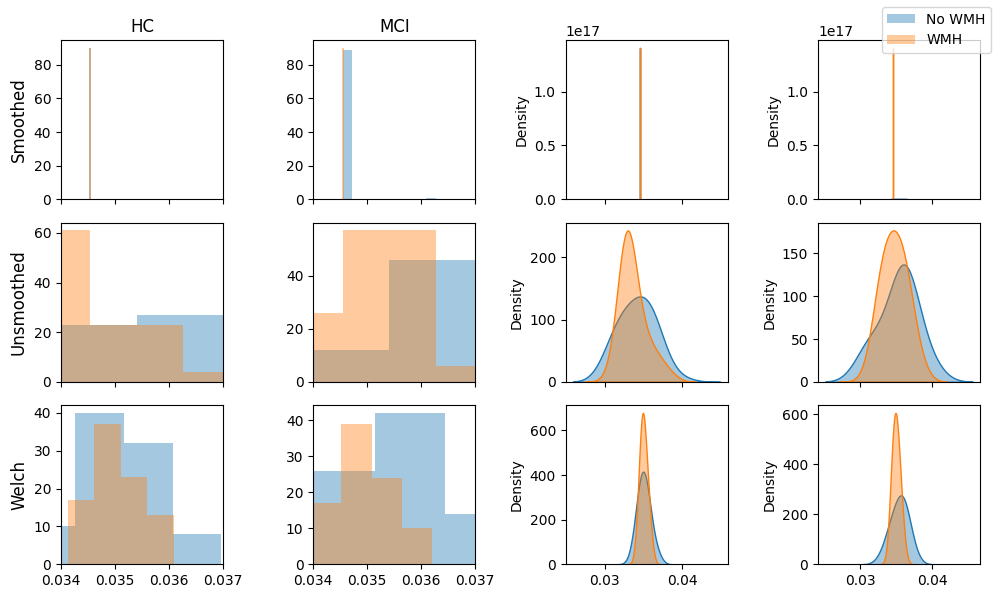

In [73]:
print(f"These are the unique values of intrinsic frequencies for HC no WMH: {np.unique(f_diff_hc_no_wmh_smooth)}")
print(f"These are the unique values of intrinsic frequencies for HC WMH: {np.unique(f_diff_hc_wmh_smooth)}")
print(f"These are the unique values of intrinsic frequencies for MCI no WMH: {np.unique(f_diff_mci_no_wmh_smooth)}")
print(f"These are the unique values of intrinsic frequencies for MCI WMH: {np.unique(f_diff_mci_wmh_smooth)}")
# Plot the different distributions 
cols = ["HC", "MCI"]
rows = ["Smoothed", "Unsmoothed", "Welch"]

fig, axs = plt.subplots(3, 4, figsize=(10, 6), sharex='col')
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size="large")

# Add a microscopic amount of noise just for better plotting, otherwise I get a huge and ugly rectangle instead than a bar
axs[0, 0].hist(f_diff_hc_no_wmh_smooth + np.random.randn(90)*0.00001, bins = 1, label="No WMH", alpha=0.4)
axs[0, 0].hist(f_diff_hc_wmh_smooth + np.random.randn(90)*0.00001, bins = 1, label="WMH", alpha=0.4)
# Add a microscopic amount of noise just for better plotting, otherwise I get a huge and ugly rectangle instead than a bar
axs[0, 1].hist(f_diff_mci_no_wmh_smooth, alpha=0.4)
axs[0, 1].hist(f_diff_mci_wmh_smooth + np.random.randn(90)*0.00001, bins = 1, alpha=0.4)
axs[0, 0].set_xlim(0.034, 0.037)
axs[0, 1].set_xlim(0.034, 0.037)

axs[1, 0].hist(f_diff_hc_no_wmh_unsmooth, alpha=0.4, bins=4)
axs[1, 0].hist(f_diff_hc_wmh_unsmooth, alpha=0.4, bins=4)
axs[1, 1].hist(f_diff_mci_no_wmh_unsmooth, alpha=0.4, bins=4)
axs[1, 1].hist(f_diff_mci_wmh_unsmooth, alpha=0.4, bins=4)

axs[2, 0].hist(ws_hc_no_wmh, alpha=0.4, bins=4)
axs[2, 0].hist(ws_hc_wmh, alpha=0.4, bins=4)

axs[2, 1].hist(ws_mci_no_wmh, alpha=0.4, bins=4)
axs[2, 1].hist(ws_mci_wmh, alpha=0.4, bins=4)

sns.kdeplot(ax=axs[0, 2], data=f_diff_hc_no_wmh_smooth, fill=True)
sns.kdeplot(ax=axs[0, 2], data=f_diff_hc_wmh_smooth, fill=True, alpha=0.4)
sns.kdeplot(ax=axs[0, 3], data=f_diff_mci_no_wmh_smooth, fill=True, alpha=0.4)
sns.kdeplot(ax=axs[0, 3], data=f_diff_mci_wmh_smooth, fill=True, alpha=0.4)
sns.kdeplot(
    ax=axs[1, 2], data=f_diff_hc_no_wmh_unsmooth, fill=True, bw_adjust=2, alpha=0.4
)
sns.kdeplot(
    ax=axs[1, 2], data=f_diff_hc_wmh_unsmooth, fill=True, bw_adjust=2, alpha=0.4
)
sns.kdeplot(
    ax=axs[1, 3], data=f_diff_mci_no_wmh_unsmooth, bw_adjust=2, fill=True, alpha=0.4
)
sns.kdeplot(
    ax=axs[1, 3], data=f_diff_mci_wmh_unsmooth, bw_adjust=2, fill=True, alpha=0.4
)

sns.kdeplot(ax=axs[2, 2], data=ws_hc_no_wmh, fill=True, bw_adjust=2, alpha=0.4)
sns.kdeplot(ax=axs[2, 2], data=ws_hc_wmh, fill=True, bw_adjust=2, alpha=0.4)
sns.kdeplot(ax=axs[2, 3], data=ws_mci_no_wmh, bw_adjust=2, fill=True, alpha=0.4)
sns.kdeplot(ax=axs[2, 3], data=ws_mci_wmh, bw_adjust=2, fill=True, alpha=0.4)
fig.legend()
fig.tight_layout()
plt.savefig(RES_DIR / 'intrinsic_frequencies_different_methods.png')

As previously stated, it seems that the smoothing gets rid of all the variance in the intrinsic frequencies differences between groups! Maybe this could influence results. The unsmoothed and Welch methods seem to give very similar results. So maybe the Welch method might be appropriate as well + it's one line of code vs. several functions, but I need to test it more before changing. Nonetheless, the ranges of intrinsic frequencies calculated by the 3 methods seem very similar.

Another doubt I had was regarding the zscore of the timeseries.. Here we try to convince us that I did right.
First, we select a random patient. If we select one timeseries from a brain region for this patient, the only way to have a z-score using stats.zscore is by using axis = 0.
Axis = 1 raises an error.

In [77]:
ts = all_fMRI_clean['ADNI002S1261'] 

ts_r0 = stats.zscore(ts[0], axis = 0)
ts_r0 = stats.zscore(ts[0], axis = 1)

AxisError: axis 1 is out of bounds for array of dimension 1

So we convince ourselves that the right way for a single roi is axis = 0. If we have multiple timeseries we loop through each and we calculate the z-score with axis = 0 (timeseries in the center). Without looping, but applying the z-score to the (90,193) np.array, we try both axis = 1 (first row) and axis = 0 (third row) and plot the obtained timeseries.

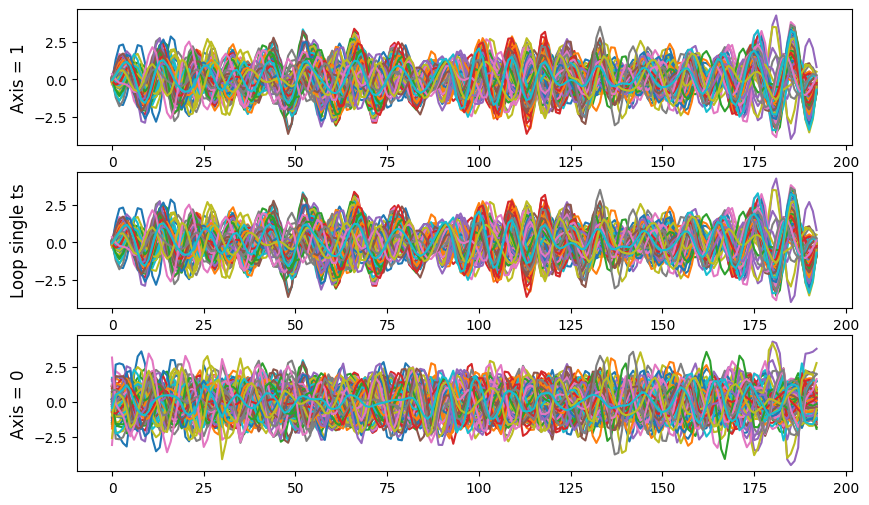

In [79]:
rows = ["Axis = 1", "Loop single ts", "Axis = 0"]

fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for ax, row in zip(axs[:,], rows):
    ax.set_ylabel(row, rotation=90, size="large")

ts_zz = stats.zscore(ts, axis = 1)
axs[0].plot(np.arange(193), ts_zz.T);

for ts_roi in ts:
    ts_z = stats.zscore(ts_roi, axis = 0)
    axs[1].plot(np.arange(193), ts_z)

ts_zz0 = stats.zscore(ts, axis = 0)
axs[2].plot(np.arange(193), ts_zz0.T);

We can see that the timeseries graph resulting from using stats.zscore(ts, axis = 1) is the correct choice if we use the array containing all the brain regions - multiple dimensions (90,193). So I did it correctly.